In [1]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ParameterGrid
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import numpy as np
import pandas as pd
#import tensorflow as tf
import matplotlib.pyplot as plt
from keras.models import load_model
from sklearn.metrics import mean_squared_error
import random
import pickle
import joblib

import sys
import uproot  # Pour lire les fichiers ROOT sans PyROOT
import awkward as ak  # uproot utilise awkward pour gérer les structures complexes
import os

from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error

from scipy.stats.distributions import uniform, skewnorm
import keras

from sklearn.metrics import accuracy_score
# import packages for hyperparameters tuning
#import hyperopt
#from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

from sklearn.utils import shuffle
from keras.models import Sequential, Model
from keras.layers import Dense, LeakyReLU, PReLU, Dropout, Input
from sklearn.model_selection import KFold
from keras.callbacks import ModelCheckpoint
from sklearn.model_selection import ParameterSampler
shuffle_on= True
from sklearn.preprocessing import MinMaxScaler

##### Define for user #####
root_df = 'D:/PYTHON/Data_ML/'
root_models = 'D:/PYTHON/Data_ML/'

keras.__version__

'3.3.3'

In [2]:
def process_root_file(filename, histname, norm):
    """
    Process a ROOT file, access an histogram, and return a DataFrame with normalized bin values.

    Parameters:
    filename (str): The path to the ROOT file.
    histname (str): The name of the histogram inside the ROOT file.

    Returns:
    pd.DataFrame: A DataFrame containing the normalized bin values.
    """
    try:
        # Ouvrir le fichier ROOT
        file = uproot.open(filename)

        # Vérifier si l'histogramme existe
        if histname not in file:
            print(f"Erreur : L'histogramme {histname} n'existe pas dans le fichier.")
            return pd.DataFrame()

        # Lire l'histogramme
        hist = file[histname]
        bin_values = hist.values()
        integral = sum(bin_values)/norm
        #integral=1

        # Vérifier si l'intégrale est non nulle pour éviter la division par zéro
        if integral == 0:
            print("Erreur : L'intégrale des valeurs des bins est nulle.")
            return pd.DataFrame()

        # Calculer l'incertitude pour chaque bin (10% de la valeur du bin)
        bin_uncertainties = 0.1 * bin_values/norm

        # Calculer l'incertitude sur l'intégrale
        integral_uncertainty = np.sqrt(np.sum(bin_uncertainties**2))

        # Normaliser les valeurs des bins et les stocker dans un DataFrame
        results = {f'PSL_IP_{i+1}': [(value/norm) / integral] for i, value in enumerate(bin_values)}
        results_df = pd.DataFrame(results)

        # Calculer l'incertitude pour chaque bin normalisé
        uncert = {}
        for i, value in enumerate(bin_values):
            if value == 0:
                uncert[f'Delta_PSL_IP_{i+1}'] = [0]
            else:
                normalized_uncertainty = ((value/norm) / integral) * np.sqrt((bin_uncertainties[i] / (value/norm))**2 + (integral_uncertainty / integral)**2)
                uncert[f'Delta_PSL_IP_{i+1}'] = [normalized_uncertainty]

        uncert_df = pd.DataFrame(uncert)

        return results_df, uncert_df, integral

    except Exception as e:
        print(f"Une erreur s'est produite : {e}")
        return pd.DataFrame()

In [3]:
def plot_histogram(results_df, uncert_df):
    """
    Plot a histogram from the normalized bin values in a DataFrame with error bars.

    Parameters:
    results_df (pd.DataFrame): A DataFrame containing the normalized bin values.
    uncert_df (pd.DataFrame): A DataFrame containing the uncertainties for each bin.
    """
    # Extraire les valeurs et les étiquettes du DataFrame
    bin_values = results_df.values.flatten()  # Flatten pour obtenir un tableau 1D
    bin_labels = results_df.columns
    uncert_values = uncert_df.values.flatten()  # Flatten pour obtenir un tableau 1D

    # Tracer l'histogramme avec des barres d'erreur
    plt.figure(figsize=(10, 6))
    plt.bar(bin_labels, bin_values, yerr=uncert_values, color='skyblue', alpha=0.7, capsize=5)
    plt.xlabel('Bin Labels')
    plt.ylabel('Normalized Bin Values')
    plt.title('Histogram of Normalized Bin Values with Uncertainties')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

In [4]:
def prepare_input_for_keras(results):
    """
    Convert the results dictionary into a NumPy array suitable for Keras model input.

    Parameters:
    results (dict): A dictionary containing the normalized bin values.

    Returns:
    np.array: A NumPy array with the values to be used as input for the Keras model.
    """
    # Extraire les valeurs du dictionnaire et les convertir en tableau NumPy
    input_data = np.array(list(results.values())).reshape(1, -1)
    return input_data

In [5]:
def predict_with_keras_model(model, input_data):
    """
    Load a Keras model and make predictions using the provided input data.

    Parameters:
    model_path (str): The path to the Keras model file.
    input_data (np.array): The input data for the model.

    Returns:
    np.array: The predictions made by the model.
    """

    # Faire des prédictions
    predictions = model.predict(input_data)
    return predictions

In [6]:
def inverse_transform_predictions(scaler_y, predictions):
    """
    Inverse transform the predictions using the provided MinMaxScaler for y.

    Parameters:
    scaler_y (MinMaxScaler): The MinMaxScaler object used for normalizing y.
    predictions (np.array): The predictions made by the model.

    Returns:
    np.array: The inverse transformed predictions.
    """
    # Inverser la transformation pour les prédictions
    original_predictions = scaler_y.inverse_transform(predictions)
    return original_predictions

In [7]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score

def plot_predictions(predictions_gauss, predictions, scale, file_path, norm):
    """
    Plot the predictions as a histogram and display the ratio between predicted and actual values.
    Also computes and displays R² values.
    """
    bin_values_pred = predictions[0] * scale
    bin_values_pred_gauss = predictions_gauss[0] * scale
    bin_labels = np.linspace(0, 5000, 501)

    with uproot.open(file_path) as file:
        histogram = file['incident_energy']
        bin_edges = histogram.axis().edges()
        bin_values = histogram.values() / norm

    # 🔹 Suppression du premier bin
    bin_edges_filtered = bin_edges[1:]
    bin_values_filtered = bin_values[1:]
    bin_labels_filtered = bin_labels[1:]
    bin_values_pred_filtered = bin_values_pred[1:]
    bin_values_pred_gauss_filtered = bin_values_pred_gauss[1:]

    # 🔹 Calcul des coefficients R² (sans le premier bin)
    r2_standard = r2_score(bin_values_filtered, bin_values_pred_filtered)
    r2_gauss = r2_score(bin_values_filtered, bin_values_pred_gauss_filtered)

    # 🔹 Calcul du ratio pour le sous-graphe
    epsilon = 1e-1  # Évite la division par zéro
    ratio_standard = bin_values_pred_filtered / (bin_values_filtered + epsilon)
    ratio_gauss = bin_values_pred_gauss_filtered / (bin_values_filtered + epsilon)

    # 🔹 Suppression des valeurs nulles dans le ratio
    ratio_standard[bin_values_filtered == 0] = np.nan
    ratio_gauss[bin_values_filtered == 0] = np.nan

    # 🔹 Création des figures avec sous-graphe
    fig, ax1 = plt.subplots(figsize=(12, 8), nrows=2, sharex=True, gridspec_kw={'height_ratios': [3, 1]})

    # 🔵 Graph principal (Histogramme)
    ax1[0].bar(bin_edges_filtered[:-1], bin_values_filtered, width=np.diff(bin_edges_filtered), 
               color='black', alpha=0.95, align='edge', linewidth=1, label='Réel')
    ax1[0].bar(bin_labels_filtered[:-1], bin_values_pred_filtered, width=np.diff(bin_labels_filtered), 
               color='blue', alpha=0.5, label=f'Prédiction standard\nR²={r2_standard:.4f}')
    ax1[0].bar(bin_labels_filtered[:-1], bin_values_pred_gauss_filtered, width=np.diff(bin_labels_filtered), 
               color='red', alpha=0.5, label=f'Prédiction Gaussienne\nR²={r2_gauss:.4f}')

    ax1[0].set_ylabel('Valeurs prédites')
    ax1[0].set_yscale('log')
    ax1[0].set_ylim(1, None)  # Forcer le début de Y à 1
    ax1[0].set_xlim(0, 5000)  # 📌 Ajustement de l'échelle horizontale
    ax1[0].legend()

    # 🔴 Sous-graphe : Ratio en échelle logarithmique
    ax1[1].plot(bin_labels_filtered[:-1], ratio_standard, color='blue', label='Ratio Standard')
    ax1[1].plot(bin_labels_filtered[:-1], ratio_gauss, color='red', label='Ratio Gaussien')

    ax1[1].axhline(y=1, color='gray', linestyle='--', label='Ratio = 1')  # Référence idéale
    ax1[1].set_ylabel('Ratio Prédiction / Réel')
    ax1[1].set_xlabel('Bins')
    ax1[1].set_yscale('log')  # 📌 Échelle logarithmique pour le ratio
    ax1[1].set_ylim(10**-1, 10**1)  # Ajuster pour voir les écarts
    ax1[1].set_xlim(0, 5000)  # 📌 Ajustement de l'échelle horizontale
    ax1[1].legend()

    plt.tight_layout()
    plt.show()


In [8]:
# Exemple d'utilisation
# Charger les scalers
with open(root_models + 'gpy/' + 'scaler_X.pkl', 'rb') as f:
    scaler_X = pickle.load(f)

with open(root_models + 'gpy/' + 'scaler_Y.pkl', 'rb') as f:
    scaler_y = pickle.load(f)

with open(root_models + 'gpy/' + 'best.pkl', 'rb') as file:
#with open(root_models + 'gpy/' + 'best.pkl', 'rb') as file:
    nn_model_gauss = pickle.load(file)

nn_model = load_model(root_models+'nn/'+'direct_test.keras')

In [46]:
#path_file = "D:\PYTHON\spectra\Exp_20keV_100M.root"
path_file = "D:\PYTHON\Test\TEST_Spectrum_13_10M.root"
normalisation=1
results, uncert, integral = process_root_file(path_file, "PSL vs IP", normalisation)
print(results)
print(uncert)
print(integral)
integral_bis = integral/(3.1415*6.5*6.5)
print(integral_bis)

   PSL_IP_1  PSL_IP_2  PSL_IP_3  PSL_IP_4  PSL_IP_5  PSL_IP_6  PSL_IP_7  \
0  0.311031    0.1805  0.126443  0.085009  0.059411  0.052271  0.038195   

   PSL_IP_8  PSL_IP_9  PSL_IP_10  PSL_IP_11  PSL_IP_12  PSL_IP_13  PSL_IP_14  \
0  0.028194  0.025153   0.024251   0.021855   0.020055   0.014477   0.008033   

   PSL_IP_15  
0   0.005122  
   Delta_PSL_IP_1  Delta_PSL_IP_2  Delta_PSL_IP_3  Delta_PSL_IP_4  \
0        0.033549        0.019469        0.013639        0.009169   

   Delta_PSL_IP_5  Delta_PSL_IP_6  Delta_PSL_IP_7  Delta_PSL_IP_8  \
0        0.006408        0.005638         0.00412        0.003041   

   Delta_PSL_IP_9  Delta_PSL_IP_10  Delta_PSL_IP_11  Delta_PSL_IP_12  \
0        0.002713         0.002616         0.002357         0.002163   

   Delta_PSL_IP_13  Delta_PSL_IP_14  Delta_PSL_IP_15  
0         0.001562         0.000866         0.000552  
4426.510390110808
33.35014378131886


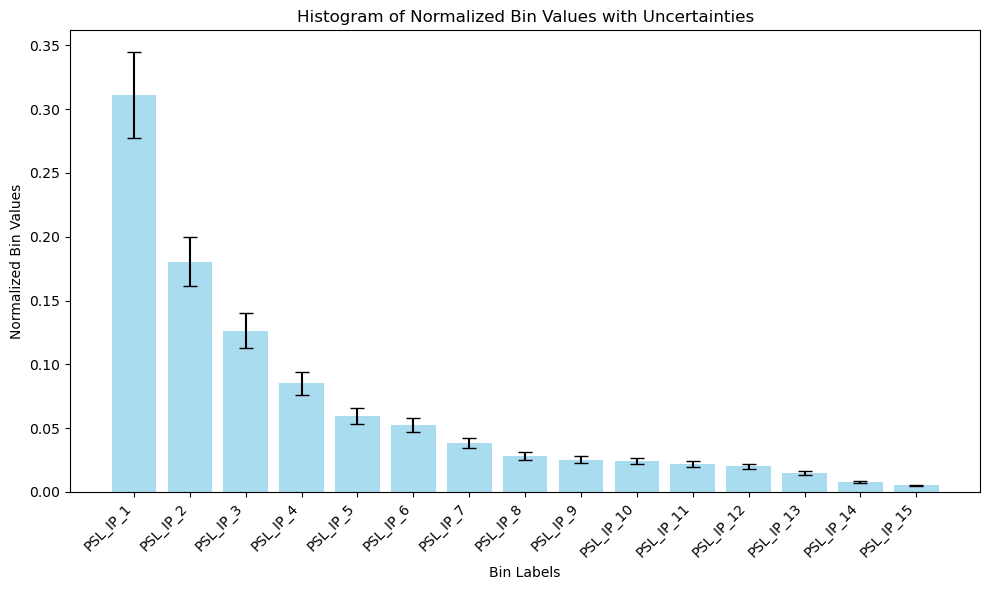

In [47]:
plot_histogram(results, uncert)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


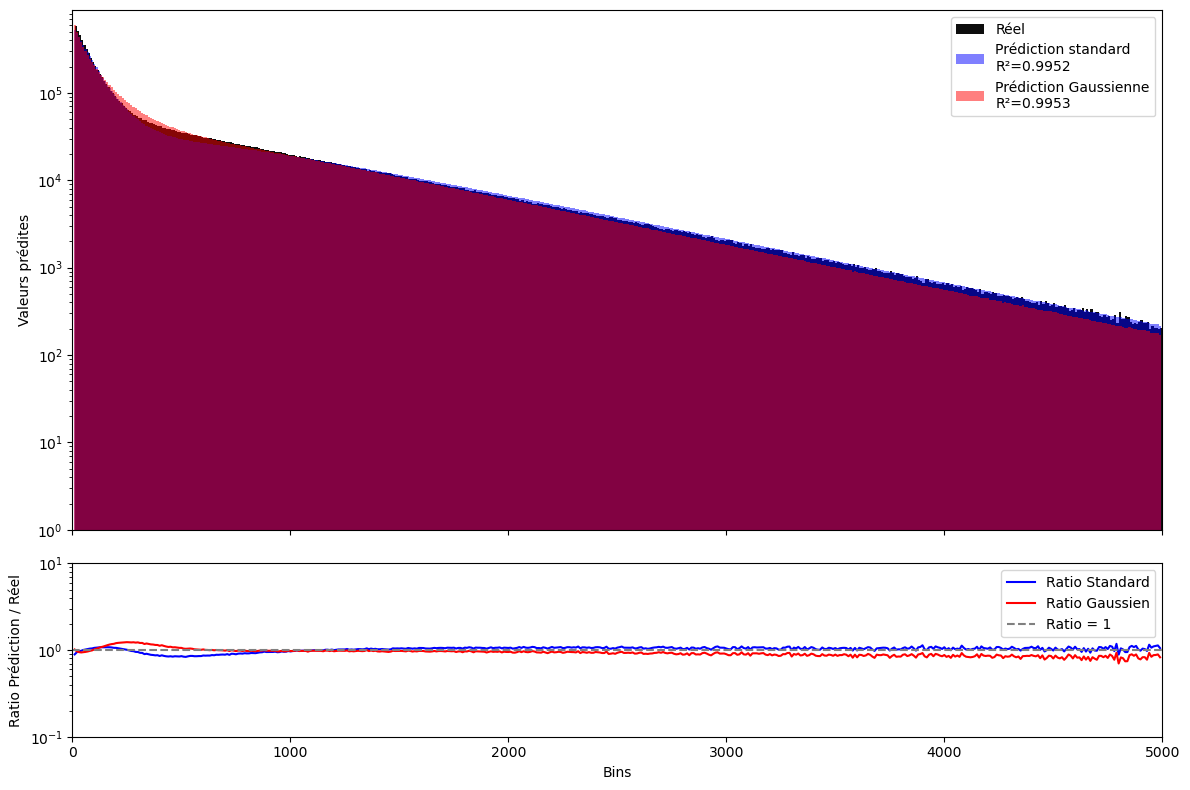

In [48]:
input_data_scaled = scaler_X.transform(results)
# Faire des prédictions
#predictions = predict_with_keras_model(root_models+'nn/'+'direct_test.keras', input_data_scaled)
predictions_gauss = nn_model_gauss.predict(input_data_scaled)
predictions = nn_model.predict(input_data_scaled)
#print('Prédictions :', predictions)
# Inverser la transformation
original_predictions_gauss = inverse_transform_predictions(scaler_y, predictions_gauss)
original_predictions = inverse_transform_predictions(scaler_y, predictions)
#print('Prédictions :', original_predictions)
plot_predictions(original_predictions_gauss, original_predictions, integral_bis, path_file, normalisation)

In [14]:
import os
import pickle
import numpy as np
import uproot
from sklearn.metrics import r2_score
from tensorflow.keras.models import load_model

# 📂 Dossier contenant les fichiers ROOT
folder_path = "D:/PYTHON/Test/"

# 📌 Charger les scalers
with open(root_models + 'gpy/' + 'scaler_X.pkl', 'rb') as f:
    scaler_X = pickle.load(f)

with open(root_models + 'gpy/' + 'scaler_Y.pkl', 'rb') as f:
    scaler_y = pickle.load(f)

# 📌 Charger les modèles
with open(root_models + 'gpy/' + 'best.pkl', 'rb') as file:
    nn_model_gauss = pickle.load(file)

nn_model = load_model(root_models + 'nn/' + 'direct_test.keras')

# 🔹 Stockage des résultats
r2_values_standard = []
r2_values_gauss = []
file_indices = []

# 🔄 Boucle sur tous les fichiers ROOT du dossier
for i, file_name in enumerate(sorted(os.listdir(folder_path))):
    if file_name.endswith('.root'):
        file_path = os.path.join(folder_path, file_name)
        normalisation = 1  # À adapter si nécessaire
        
        try:
            # 🔹 Charger les données du fichier ROOT
            results, uncert, integral = process_root_file(file_path, "PSL vs IP", normalisation)
            integral_bis = integral/(3.1415*6.5*6.5)
            input_data_scaled = scaler_X.transform(results)

            # 🔹 Faire des prédictions
            predictions_gauss = nn_model_gauss.predict(input_data_scaled)
            predictions = nn_model.predict(input_data_scaled)

            # 🔹 Inverser la transformation
            original_predictions_gauss = inverse_transform_predictions(scaler_y, predictions_gauss)
            original_predictions = inverse_transform_predictions(scaler_y, predictions)

            # 🔹 Mise à l'échelle des prédictions
            bin_values_pred = original_predictions[0] * integral_bis
            bin_values_pred_gauss = original_predictions_gauss[0] * integral_bis
            bin_labels = np.linspace(0, 5000, 501)

            # 🔹 Charger l'histogramme du fichier ROOT
            with uproot.open(file_path) as file:
                histogram = file['incident_energy']
                bin_edges = histogram.axis().edges()
                bin_values = histogram.values() / normalisation

            # 🔹 Filtrer les bins < 1 pour éviter les erreurs dans le R²
            mask = bin_values >= 0.1
            if np.sum(mask) > 0:
                r2_standard = r2_score(bin_values[mask], bin_values_pred[mask])
                r2_gauss = r2_score(bin_values[mask], bin_values_pred_gauss[mask])
            else:
                r2_standard, r2_gauss = np.nan, np.nan  # Évite les erreurs

            # 🔹 Stocker les résultats
            r2_values_standard.append(r2_standard)
            r2_values_gauss.append(r2_gauss)
            file_indices.append(i + 1)  # Index numérique du fichier

            print(f"✅ Fichier {file_name} traité - R² Standard: {r2_standard:.3f}, R² Gaussien: {r2_gauss:.3f}")

        except Exception as e:
            print(f"❌ Erreur lors du traitement de {file_name}: {e}")

# 📊 Résumé des résultats
print("\n📌 Résumé des R² pour tous les fichiers traités :")
for idx, (r2_std, r2_gauss) in zip(file_indices, zip(r2_values_standard, r2_values_gauss)):
    print(f"Fichier {idx}: R² Standard = {r2_std:.3f}, R² Gaussien = {r2_gauss:.3f}")




1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
✅ Fichier TEST_Exp_1000keV_10M.root traité - R² Standard: -827.489, R² Gaussien: -39.517
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
✅ Fichier TEST_Exp_100keV_10M.root traité - R² Standard: -8.571, R² Gaussien: 0.993
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
✅ Fichier TEST_Exp_101keV_10M.root traité - R² Standard: -8.742, R² Gaussien: 0.998
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
✅ Fichier TEST_Exp_102keV_10M.root traité - R² Standard: -7.992, R² Gaussien: 0.998
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
✅ Fichier TEST_Exp_103keV_10M.root traité - R² Standard: -8.309, R² Gaussien: 0.995
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
✅ Fichier TEST_Exp_104keV_10M.root traité - R² Standard: -8.428, R² Gaussien: 0.965
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
✅ Fichier TEST_Exp_105keV_10M.root traité - R² Standard: -7.929, R² Gaussien: 0.974
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
✅ Fichier TEST_Exp_106keV_10M.root traité - R² Standard: -7.738, R² Gaussien: 1.000
1/1 ━━━━━━━━━━━━━━━

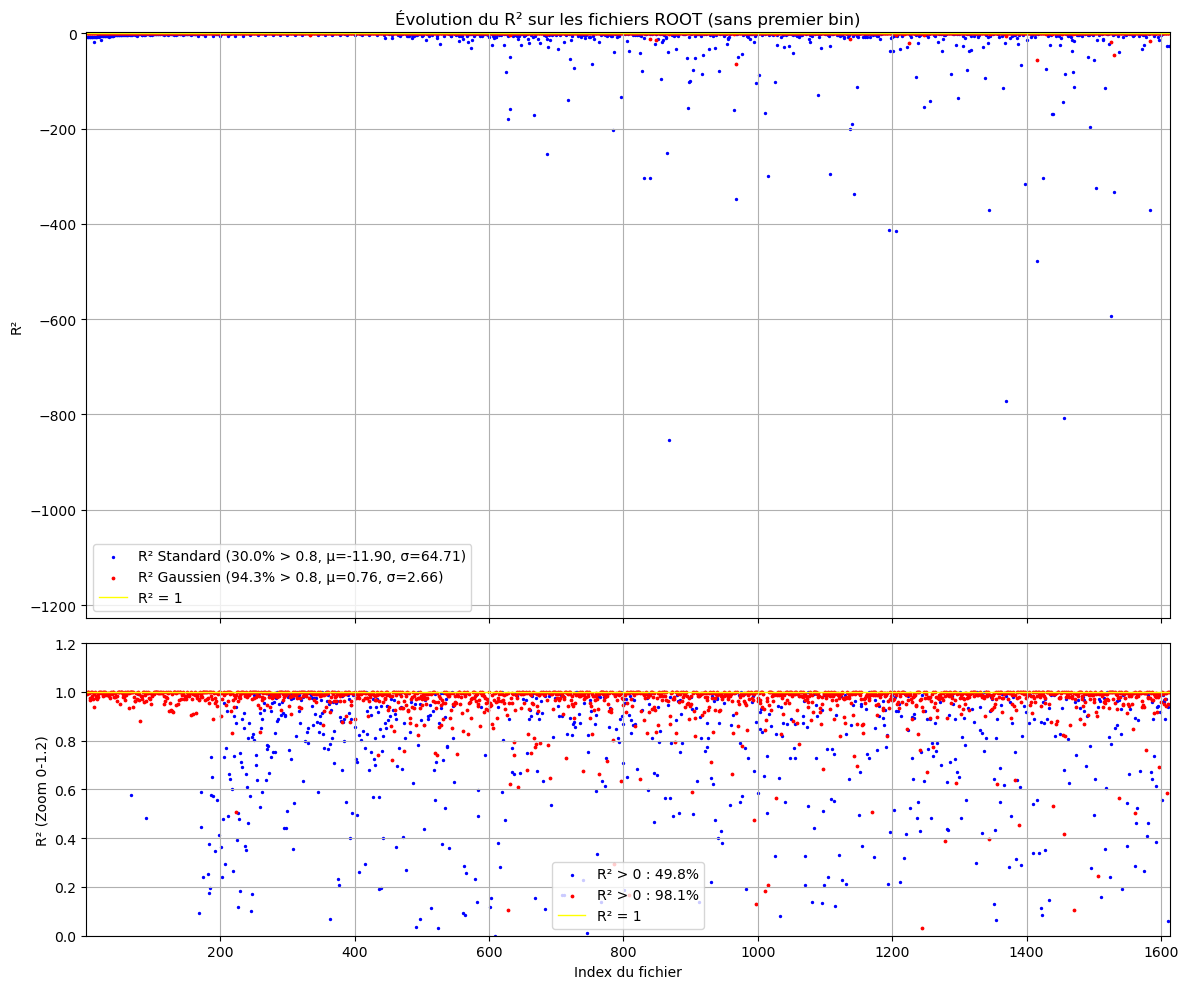

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# 📌 Suppression du premier élément des listes
file_indices_filtered = file_indices[1:]
r2_values_standard_filtered = r2_values_standard[1:]
r2_values_gauss_filtered = r2_values_gauss[1:]

# 📌 Calcul des statistiques globales SANS le premier bin
mean_r2_standard = np.mean(r2_values_standard_filtered)
std_r2_standard = np.std(r2_values_standard_filtered)
mean_r2_gauss = np.mean(r2_values_gauss_filtered)
std_r2_gauss = np.std(r2_values_gauss_filtered)

# 🔹 Comptage du nombre de R² > 0.8
total_files = len(file_indices_filtered)
count_r2_standard_08 = sum(r2 > 0.8 for r2 in r2_values_standard_filtered)
count_r2_gauss_08 = sum(r2 > 0.8 for r2 in r2_values_gauss_filtered)

# 🔹 Comptage du nombre de R² > 0
count_r2_standard_0 = sum(r2 > 0 for r2 in r2_values_standard_filtered)
count_r2_gauss_0 = sum(r2 > 0 for r2 in r2_values_gauss_filtered)

# 🔹 Calcul des pourcentages
percent_r2_standard_08 = (count_r2_standard_08 / total_files) * 100
percent_r2_gauss_08 = (count_r2_gauss_08 / total_files) * 100

percent_r2_standard_0 = (count_r2_standard_0 / total_files) * 100
percent_r2_gauss_0 = (count_r2_gauss_0 / total_files) * 100

# 📊 Création de la figure avec deux sous-graphes (subplots)
fig, axes = plt.subplots(2, 1, figsize=(12, 10), sharex=True, gridspec_kw={'height_ratios': [2, 1]})

# 🔹 Premier graphe : Vue globale
axes[0].scatter(file_indices_filtered, r2_values_standard_filtered, s=2, color='blue', 
                label=f"R² Standard ({percent_r2_standard_08:.1f}% > 0.8, μ={mean_r2_standard:.2f}, σ={std_r2_standard:.2f})")
axes[0].scatter(file_indices_filtered, r2_values_gauss_filtered, s=3, color='red', 
                label=f"R² Gaussien ({percent_r2_gauss_08:.1f}% > 0.8, μ={mean_r2_gauss:.2f}, σ={std_r2_gauss:.2f})")
axes[0].axhline(y=1, color='yellow', linestyle='-', linewidth=1, label="R² = 1")

# 🔹 Ajustement des limites Y pour la vue globale
min_r2 = min(min(r2_values_standard_filtered), min(r2_values_gauss_filtered)) * 0.9
max_r2 = 2
axes[0].set_ylim(min_r2, max_r2)

# 📌 Ajustements du graphe global
axes[0].set_ylabel("R²")
axes[0].set_title("Évolution du R² sur les fichiers ROOT (sans premier bin)")
axes[0].legend()
axes[0].grid()

# 🔹 Deuxième graphe : Zoom sur [0, 1.2] en Y
axes[1].scatter(file_indices_filtered, r2_values_standard_filtered, s=2, color='blue', 
                label=f"R² > 0 : {percent_r2_standard_0:.1f}%")
axes[1].scatter(file_indices_filtered, r2_values_gauss_filtered, s=3, color='red', 
                label=f"R² > 0 : {percent_r2_gauss_0:.1f}%")
axes[1].axhline(y=1, color='yellow', linestyle='-', linewidth=1, label="R² = 1")

# 🔹 Ajustement des limites Y pour le zoom
axes[1].set_ylim(0, 1.2)

# 📌 Ajustements du graphe zoomé
axes[1].set_xlabel("Index du fichier")
axes[1].set_ylabel("R² (Zoom 0-1.2)")
axes[1].legend()
axes[1].grid()

# 🔹 Ajustement de l'axe X pour les deux graphiques
axes[0].set_xlim(min(file_indices_filtered) - 1, max(file_indices_filtered) + 1)
axes[1].set_xlim(min(file_indices_filtered) - 1, max(file_indices_filtered) + 1)

# 📌 Affichage du graphe
plt.tight_layout()
plt.show()
